#  Outliers removal/diagnostic of the data

In [1]:
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import sigma_clip
from astropy.table import Table
from astropy.timeseries import LombScargle
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import nirps_tools as nirps
import yaml
import rv_analysis_tools as rv
import importlib
importlib.reload(rv)
from matplotlib import cm

### Read input file

In [2]:
star = input('Enter star name:')

print('Loading input file and data...')
### System info
working_path = f"CRAPresults/{star}/"

# Read input file
try: 
    with open(working_path + 'input.yaml', 'r') as file:
        yaml_file = yaml.safe_load(file)
except FileNotFoundError:
    print('This star does not exist in the database.')
    raise

print('Done.')

Loading input file and data...
Done.


Matplotlib preferences

In [3]:
# Styling parameters
plt.style.use('ggplot')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'legend.fontsize': 'small',
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'small',
    'ytick.labelsize':'small',
    'figure.autolayout': True,
})

## Loading the data

In [4]:
data = rv.DataLoader(yaml_file, raw=True)

## Timeseries and periodograms

In [5]:
qty_list = {}
qty_labels = {}
qty_units = {}
qty_ccf_list = {}
qty_ccf_labels = {}
qty_ccf_units = {}

i = 0
no_Dtemp = False
for instrument in data.instruments:
    # LBL labels
    if no_Dtemp == False: qty_list[instrument] = ["vrad", "d2v","DTEMP"+data.Dtemp_suffix[instrument]]
    else: qty_list[instrument] = ["vrad", "d2v"]
    
    if no_Dtemp ==False: qty_labels[instrument] = {
        "vrad": "RV",
        "d2v": "D2V",
        "DTEMP"+data.Dtemp_suffix[instrument]: "$\Delta$T",
    }
    else: qty_labels[instrument] = {
        "vrad": "RV",
        "d2v": "D2V",
    }
    if no_Dtemp==False: qty_units[instrument] = {
        "vrad": "m/s",
        "d2v": "m$^2$ / s$^2$",
        "DTEMP"+data.Dtemp_suffix[instrument]: "K",
    }
    else: qty_units[instrument] = {
        "vrad": "m/s",
        "d2v": "m$^2$ / s$^2$",
    }
    

    i+=1

LBL data

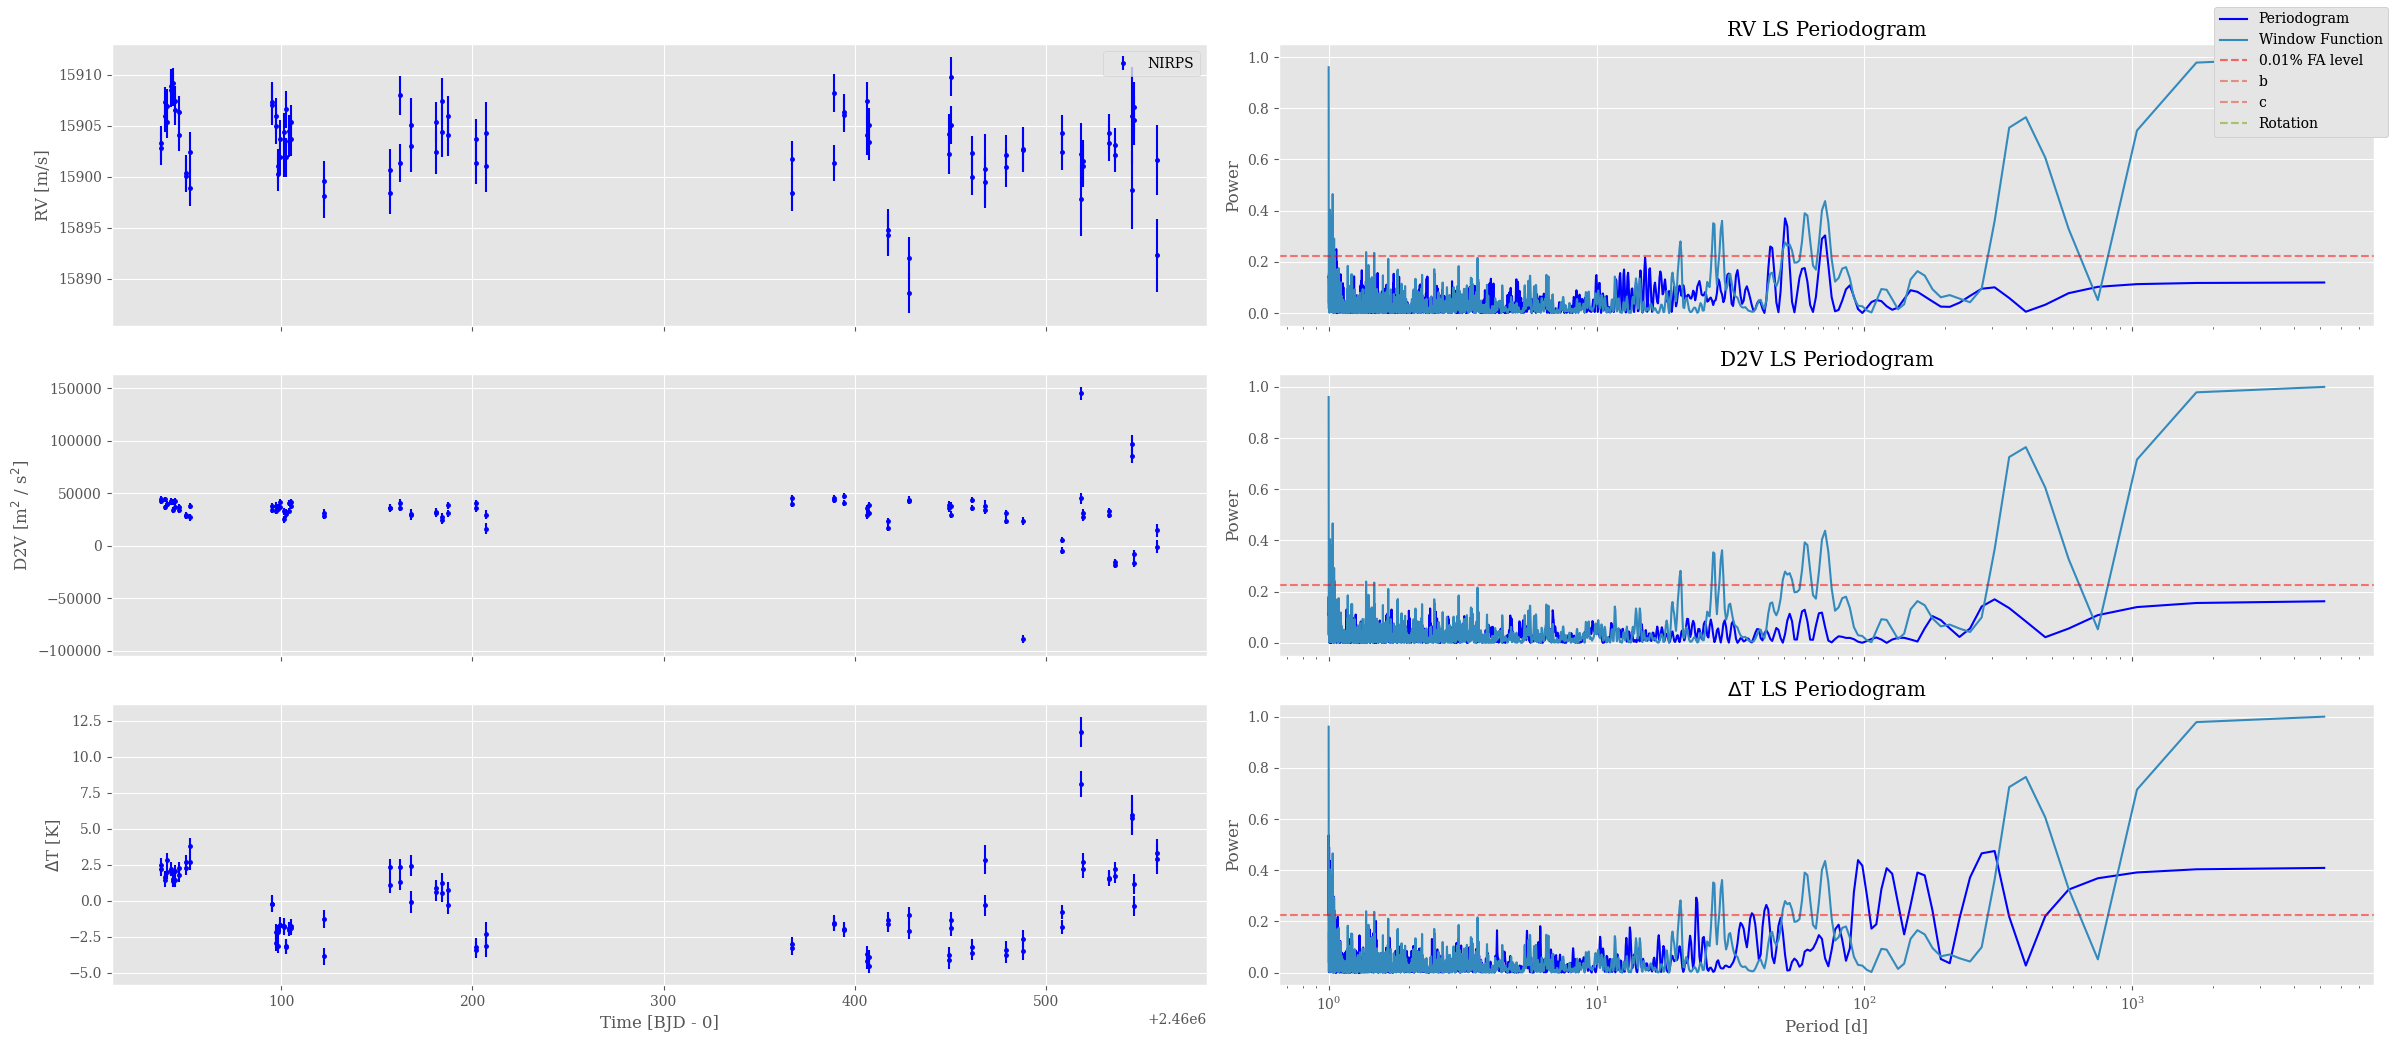

In [6]:
first_time = True
for instrument in data.instruments: 
    if first_time: 
        fig, axes = nirps.plot_timeseries(data.tbl[instrument], qty_list[instrument], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], plot_ls=True, err_label=instrument,
                candidate_planets=data.star_info['planets'], star_rotation=data.star_info['period'], color = 'blue')
    else: 
        nirps.plot_timeseries(data.tbl[instrument], qty_list[instrument], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], plot_ls=True, err_label=instrument,
                candidate_planets=data.star_info['planets'], star_rotation=data.star_info['period'], color = 'red',fig = fig, axes=axes)
        
    
    first_time = False
    
axes[0, 0].legend()
plt.savefig(f"CRAPresults/{star}/data/{star}_timeseries.png", dpi=300)
plt.show()

In [7]:
len(data.t_rv['NIRPS'])

94

In [8]:
for instrument in data.instruments: 
    data.tbl[instrument]['vrad'] -= np.median(data.tbl[instrument]['vrad'])

## Outlier filtering

In [9]:
mask_sigma = {}
mask_sigma_ccf = {}
for instrument in data.instruments: 
    mask_sigma[instrument] = nirps.sigma_clip_tbl(data.tbl[instrument], qty_list[instrument], sigma=3.0)

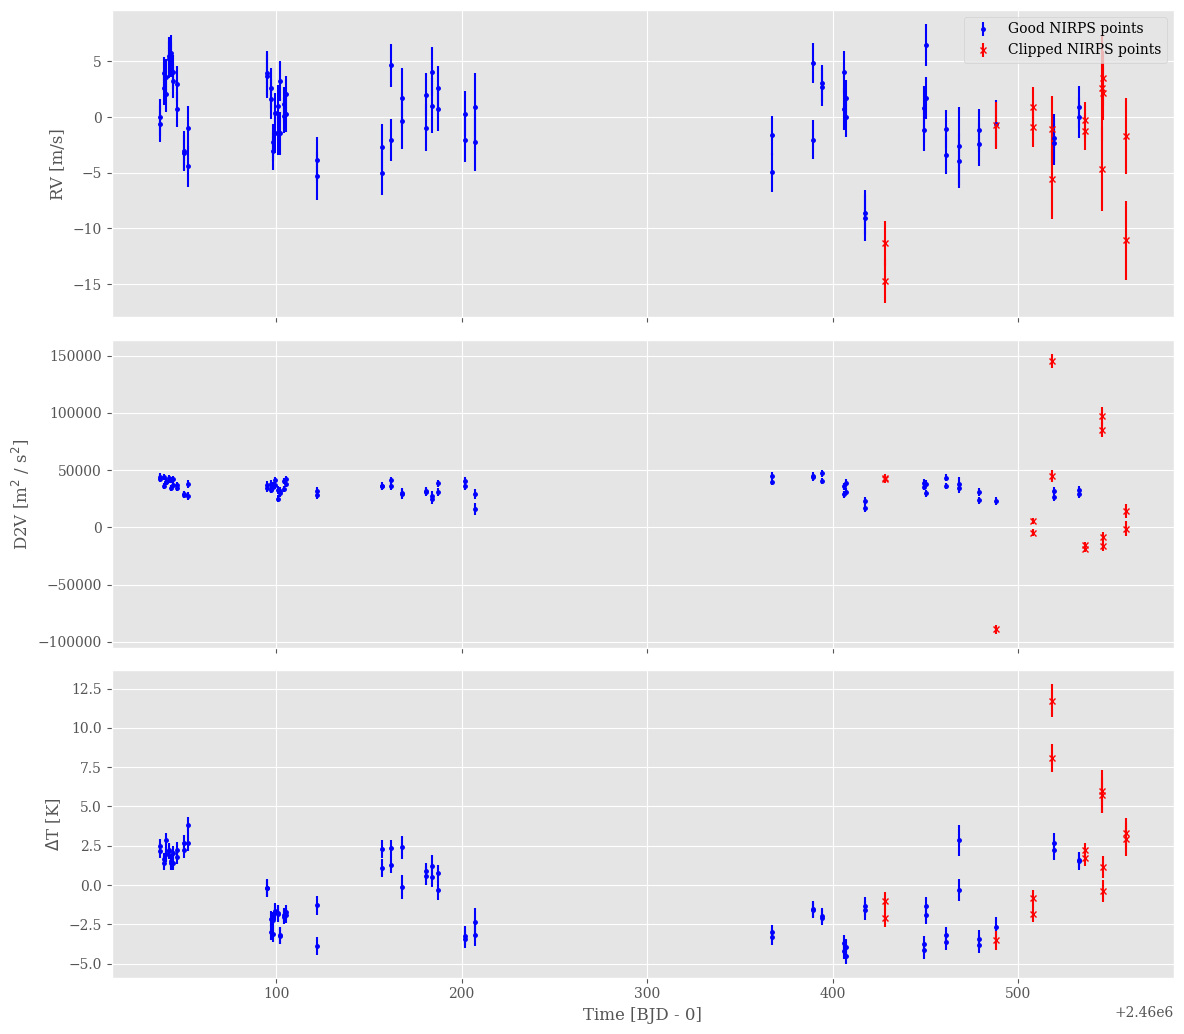

In [10]:
first_time = True
for instrument in data.instruments: 
    if first_time:
        fig, axes = nirps.plot_timeseries(
            data.tbl[instrument][~mask_sigma[instrument]], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument], plot_ls=False,
            err_label=f"Good {instrument} points", color='blue')
        
        nirps.plot_timeseries(data.tbl[instrument][mask_sigma[instrument]], 
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="rx",
        err_label=f"Clipped {instrument} points",
        color='red')
        
    else:  
        nirps.plot_timeseries(
        data.tbl[instrument][~mask_sigma[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_label=f"Good {instrument} points",
        color='purple')
        
        nirps.plot_timeseries(
        data.tbl[instrument][mask_sigma[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="rx",
        err_label=f"Clipped {instrument} points",
        color='orange')
    
    first_time = False
        
axes[0, 0].legend()
plt.show()

## Error-based filtering

NIRPS


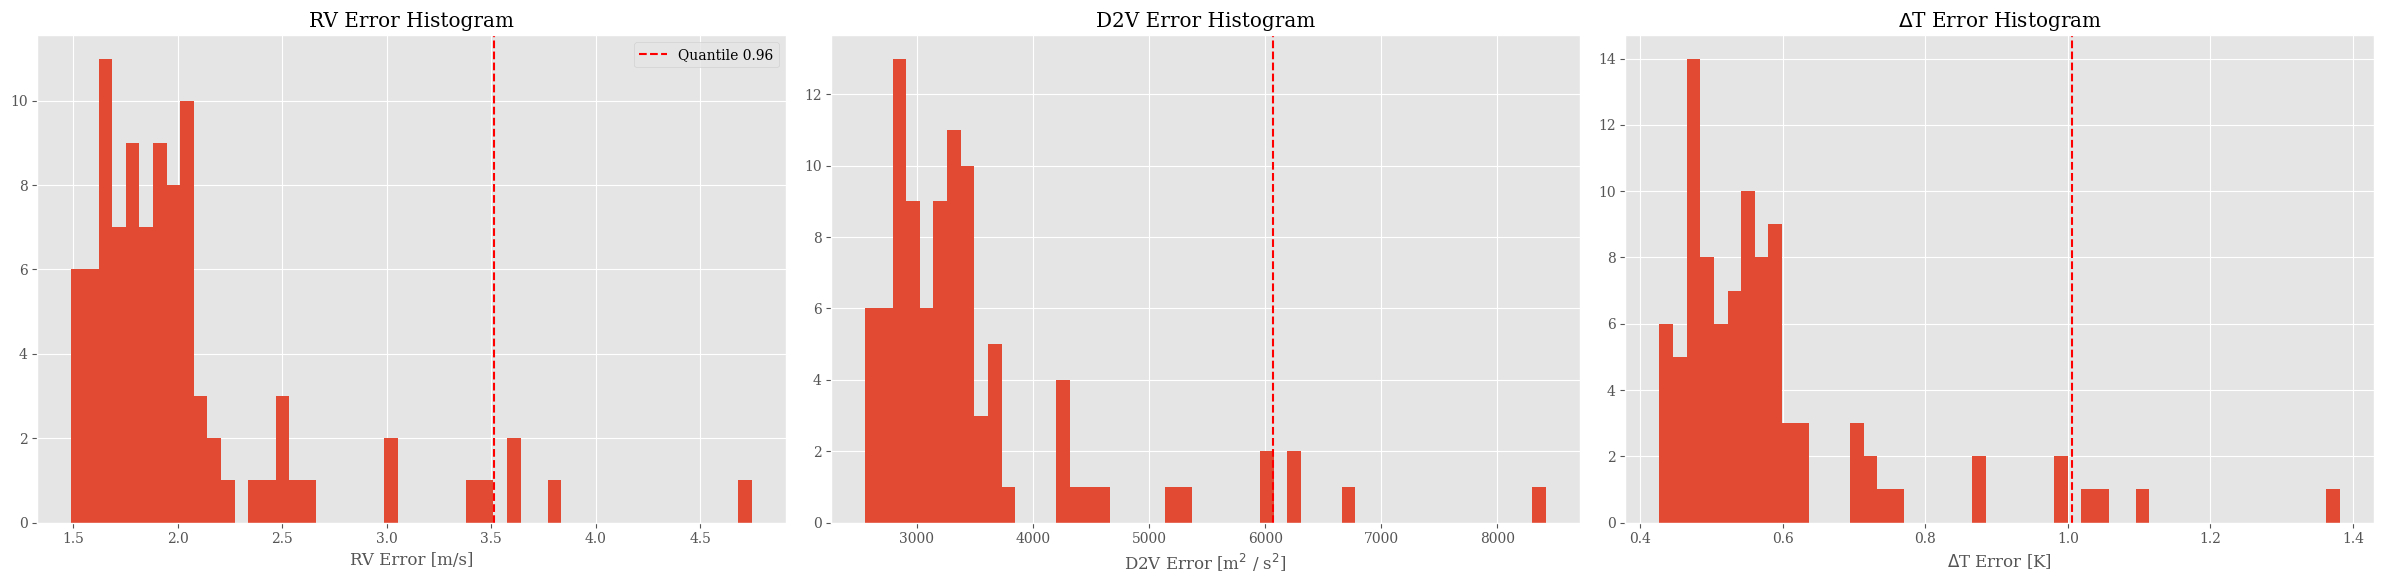

In [11]:
quantile_cut = 0.96
mask_equant = {}
mask_equant_ccf = {}

# LBL data
for instrument in data.instruments: 
    print(instrument)
    nirps.plot_error_dist(data.tbl[instrument], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument], quantile_cut=quantile_cut)
    plt.show()

    mask_equant[instrument] = nirps.error_quantile_clip(data.tbl[instrument], qty_list[instrument], quantile_cut, inc_label='s')

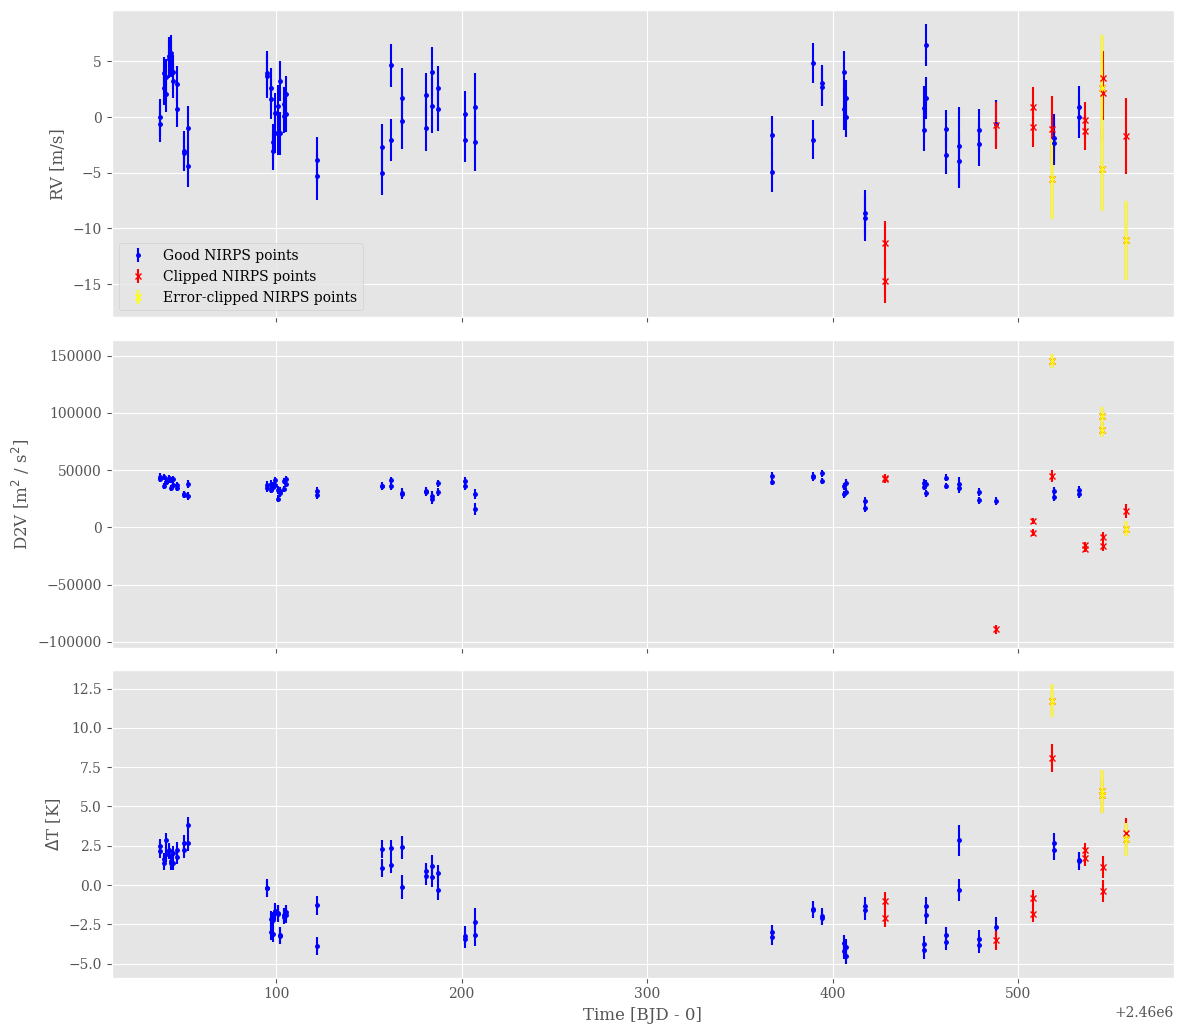

In [12]:
first_time = True
mask = {}
mask_ccf = {}

for instrument in data.instruments: 
    mask[instrument] = mask_sigma[instrument] | mask_equant[instrument]
    if first_time:
        fig, axes = nirps.plot_timeseries(
            data.tbl[instrument][~mask[instrument]], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument], plot_ls=False,
            err_label=f"Good {instrument} points", color='blue')
        
        nirps.plot_timeseries(
        data.tbl[instrument][mask_sigma[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="rx",
        err_label=f"Clipped {instrument} points",
        color='red')
        
        nirps.plot_timeseries(
        data.tbl[instrument][mask_equant[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="bx",
        err_label=f"Error-clipped {instrument} points",
        color='yellow'
    )
        
    else:  
        nirps.plot_timeseries(
        data.tbl[instrument][~mask[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_label=f"Good {instrument} points",
        color='purple')
        
        nirps.plot_timeseries(
        data.tbl[instrument][mask_sigma[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="rx",
        err_label=f"Clipped {instrument} points",
        color='orange')
        
        nirps.plot_timeseries(
        data.tbl[instrument][mask_equant[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="bx",
        err_label=f"Error-clipped {instrument} points",
        color='green'
    )
    
    first_time = False
        
axes[0, 0].legend()
plt.show()

### Preprocessed data

In [13]:
# Save the preprocessed data in a new .rdb file

i=0
for instrument in data.instruments: 

    data.tbl[instrument] = data.tbl[instrument][~mask[instrument]]
    data.tbl[instrument].write(f'CRAPresults/{data.star}/data/lbl_{instrument}_{data.star}_{data.ref_star[instrument]}_preprocessed.rdb', overwrite=True)

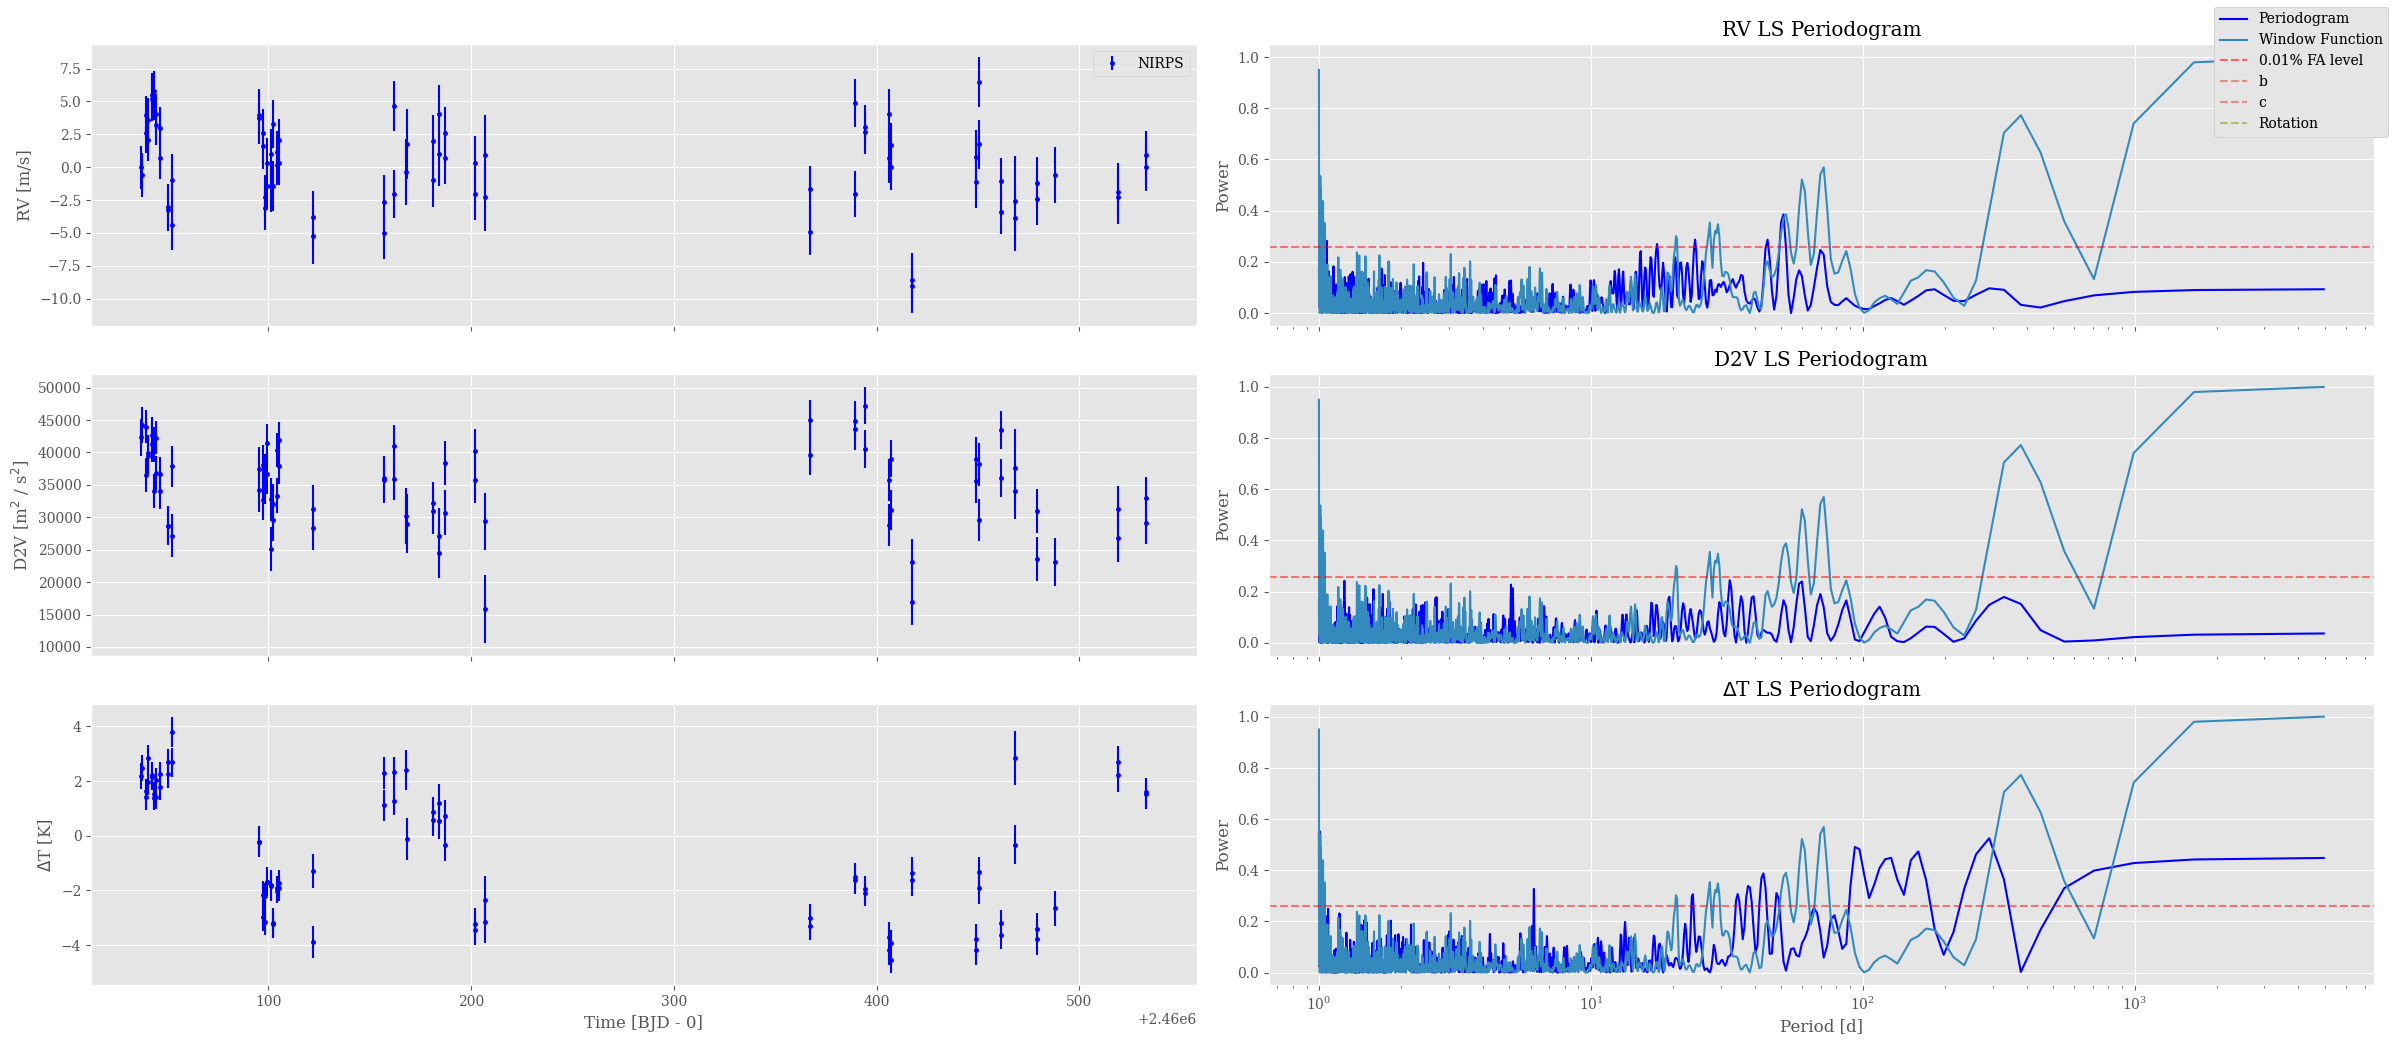

In [14]:
# Plot the preprocessed data

first_time = True
for instrument in data.instruments: 
    if first_time: 
        fig, axes = nirps.plot_timeseries(data.tbl[instrument], qty_list[instrument], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], plot_ls=True, err_label=instrument,
                candidate_planets=data.star_info['planets'], star_rotation=data.star_info['period'], color = 'blue')
    else: 
        nirps.plot_timeseries(data.tbl[instrument], qty_list[instrument], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], plot_ls=True, err_label=instrument,
                candidate_planets=data.star_info['planets'], star_rotation=data.star_info['period'], color = 'red',fig = fig, axes=axes)
        
    
    first_time = False
    
axes[0, 0].legend()
plt.savefig(f"CRAPresults/{star}/data/{star}_timeseries_after_correction.png", dpi=300)
plt.show()

# Diagnostic plots

## Chromatic slopes

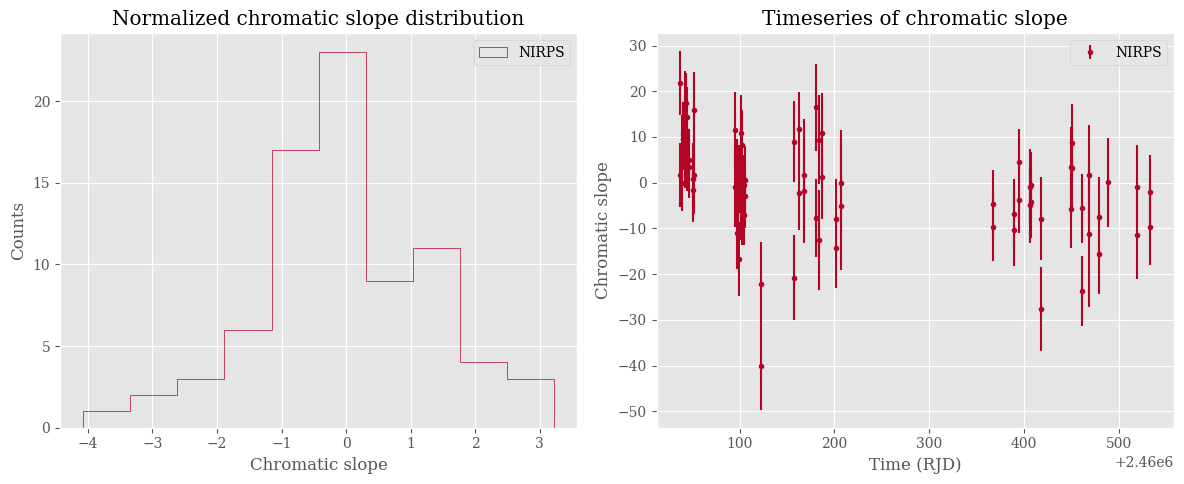

In [15]:
# Define colors for the instruments
colors = cm.coolwarm(np.linspace(1, 0, len(data.instruments)))

# Plot histograms of the chromatic slopes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loop through instruments to create histograms and timeseries
for idx, instrument in enumerate(data.instruments):
    # Histogram of normalized chromatic slope
    chromatic_slope_norm = (data.tbl[instrument]['vrad_chromatic_slope'] - 
                            np.median(data.tbl[instrument]['vrad_chromatic_slope'])) / data.tbl[instrument]['svrad_chromatic_slope']
    axes[0].hist(chromatic_slope_norm, histtype='step', label=instrument, color=colors[idx])
    
    # Timeseries of chromatic slope
    axes[1].errorbar(data.tbl[instrument]['rjd'], data.tbl[instrument]['vrad_chromatic_slope'], 
                     yerr=data.tbl[instrument]['svrad_chromatic_slope'], label=instrument, color=colors[idx], fmt='o', markersize=3)

axes[0].set_ylabel('Counts')
axes[0].set_xlabel('Chromatic slope')
axes[0].legend()
axes[0].set_title('Normalized chromatic slope distribution')

axes[1].set_xlabel('Time (RJD)')
axes[1].set_ylabel('Chromatic slope')
axes[1].set_title('Timeseries of chromatic slope')
axes[1].legend()

plt.show()


## FWHM 

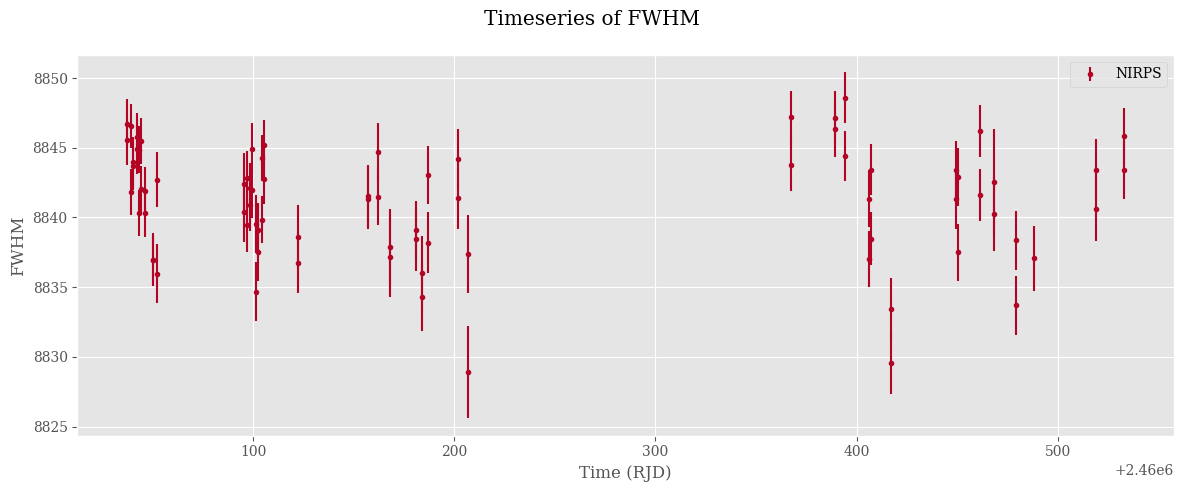

In [16]:
# Define colors for the instruments
colors = cm.coolwarm(np.linspace(1, 0, len(data.instruments)))

# Create subplots
fig, axes = plt.subplots(len(data.instruments), 1, figsize=(12, 5 * len(data.instruments)), sharex=True)

# Ensure axes is a list even if there's only one subplot
if len(data.instruments) == 1:
    axes = [axes]

# Loop through instruments to create timeseries plots
for idx, instrument in enumerate(data.instruments):
    axes[idx].errorbar(data.tbl[instrument]['rjd'], data.tbl[instrument]['fwhm'], 
                       yerr=data.tbl[instrument]['sig_fwhm'], label=instrument, color=colors[idx], fmt='o', markersize=3)
    axes[idx].set_ylabel('FWHM')
    axes[idx].legend()

axes[-1].set_xlabel('Time (RJD)')
plt.suptitle('Timeseries of FWHM')
plt.show()

## Winds for $H_2O$ and other species

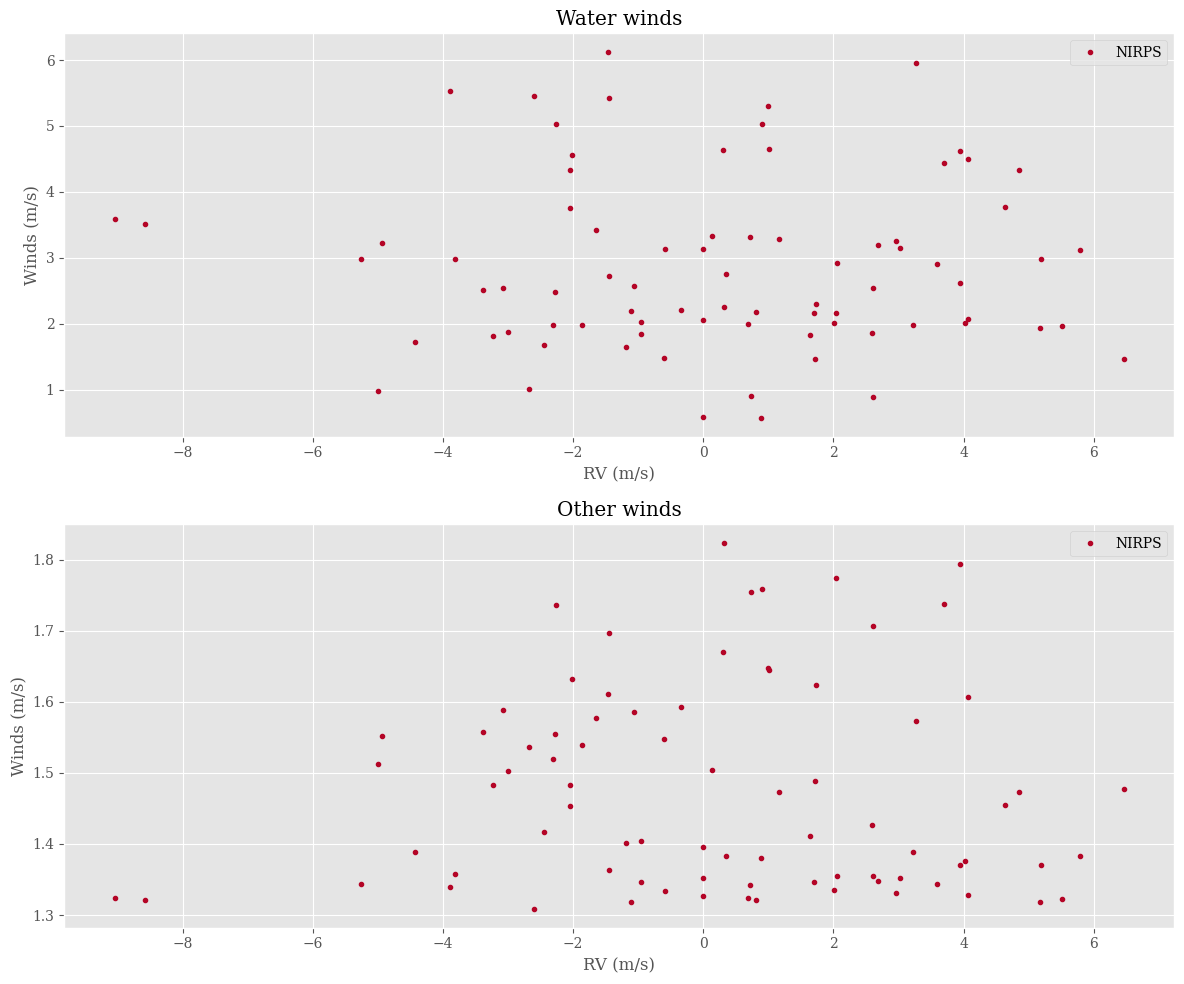

In [17]:
# Define colors for the instruments
colors = cm.coolwarm(np.linspace(1, 0, len(data.instruments)))

# Create subplots for Water winds and Other species winds
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Water winds
for idx, instrument in enumerate(data.instruments):
    axes[0].plot(data.tbl[instrument]['vrad'], data.tbl[instrument]['TLPEH2O'], 'o', label=instrument, color=colors[idx], markersize=3)
axes[0].set_xlabel('RV (m/s)')
axes[0].set_ylabel('Winds (m/s)')
axes[0].set_title('Water winds')
axes[0].legend()

# Other species winds
for idx, instrument in enumerate(data.instruments):
    axes[1].plot(data.tbl[instrument]['vrad'], data.tbl[instrument]['TLPEOTR'], 'o', label=instrument, color=colors[idx], markersize=3)
axes[1].set_xlabel('RV (m/s)')
axes[1].set_ylabel('Winds (m/s)')
axes[1].set_title('Other winds')
axes[1].legend()

plt.tight_layout()
plt.show()

## Left side/Right side of the detector

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


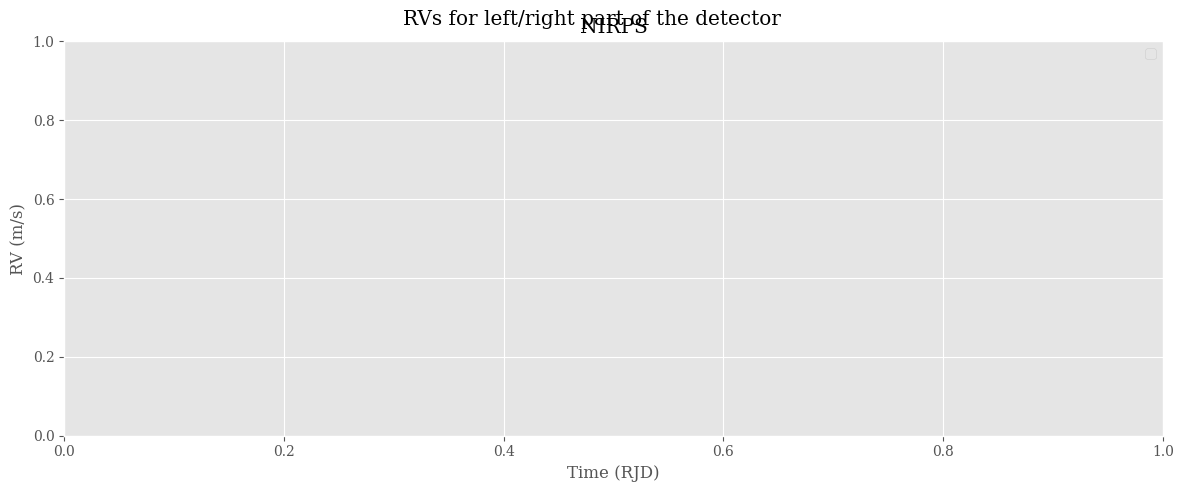

In [18]:
# Define colors for the RV segments
segment_colors = ['green', 'orange']

# Create subplots for each instrument
fig, axes = plt.subplots(len(data.instruments), 1, figsize=(12, 5 * len(data.instruments)))

if len(data.instruments) == 1:
    axes = [axes]

# Loop over instruments to plot their data
for idx, instrument in enumerate(data.instruments):
    # Loop over RV segments
    for seg_idx, color in enumerate(segment_colors):
        # Assume segment names are formatted as 'vrad_g_0-2044', 'vrad_g_2044-4088', etc.
        rv_segment = f'vrad_{instrument[0].lower()}_{seg_idx * 2044}-{(seg_idx + 1) * 2044}'
        rv_error_segment = f'svrad_{instrument[0].lower()}_{seg_idx * 2044}-{(seg_idx + 1) * 2044}'
        
        if rv_segment in data.tbl[instrument].colnames and rv_error_segment in data.tbl[instrument].colnames:
            axes[idx].errorbar(data.tbl[instrument]['rjd'], data.tbl[instrument][rv_segment], yerr=data.tbl[instrument][rv_error_segment],
                               fmt='o', color=color, label=f'{seg_idx * 2044}-{(seg_idx + 1) * 2044}', markersize=3)

    axes[idx].set_xlabel('Time (RJD)')
    axes[idx].set_ylabel('RV (m/s)')
    axes[idx].set_title(instrument)
    axes[idx].legend()

plt.tight_layout()
plt.suptitle('RVs for left/right part of the detector')
plt.show()


## $V_{tot}$

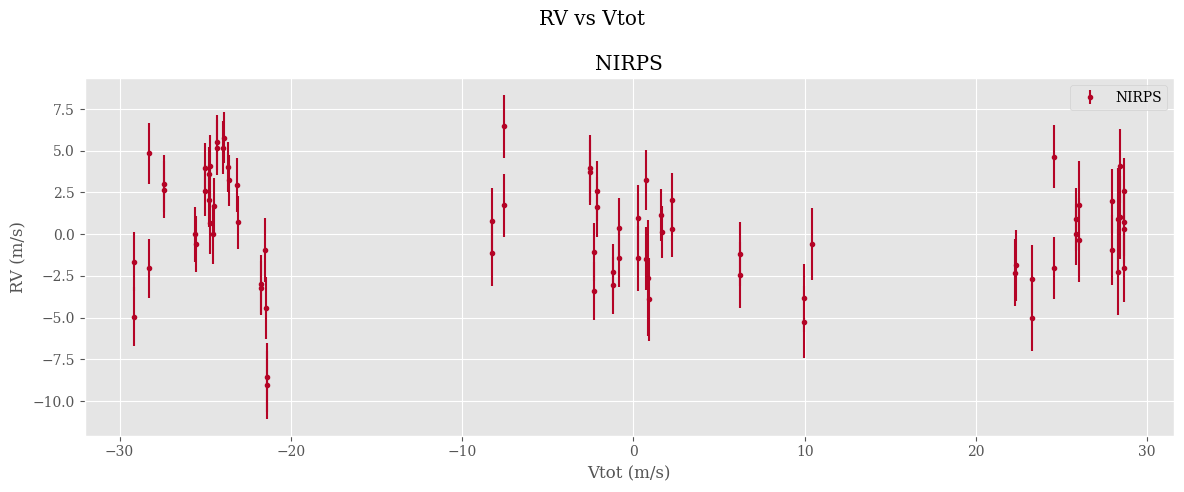

In [19]:
# Initialize a dictionary to store sorted indices and vtot for each instrument
vtot = {}
i_sort = {}

# Calculate vtot and sorted indices for each instrument
for instrument in data.instruments:
    if 'BERV' in data.tbl[instrument].colnames:
        berv_col = 'BERV'
    elif 'HIERARCH ESO DRS BERV' in data.tbl[instrument].colnames:
        berv_col = 'HIERARCH ESO DRS BERV'
    else:
        raise ValueError(f"BERV column not found for instrument {instrument}")
        
    vtot[instrument] = data.tbl[instrument]['vrad'] / 1e3 - data.tbl[instrument][berv_col]
    i_sort[instrument] = np.argsort(vtot[instrument])

# Create subplots for each instrument
fig, axes = plt.subplots(len(data.instruments), 1, figsize=(12, 5 * len(data.instruments)))
colors = cm.coolwarm(np.linspace(1, 0, len(data.instruments)))
if len(data.instruments) == 1:
    axes = [axes]

# Plot the data for each instrument
for idx, instrument in enumerate(data.instruments):
    axes[idx].errorbar(vtot[instrument][i_sort[instrument]], data.tbl[instrument]['vrad'][i_sort[instrument]], 
                       yerr=data.tbl[instrument]['svrad'][i_sort[instrument]], fmt='o', color=colors[idx], 
                       label=instrument, markersize=3)
    axes[idx].set_xlabel('Vtot (m/s)')
    axes[idx].set_ylabel('RV (m/s)')
    axes[idx].set_title(instrument)
    axes[idx].legend()

plt.suptitle('RV vs Vtot')
plt.tight_layout()
plt.show()
